South Africa Crop Type

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..") # TODO fix this hack (can't set the project directory in notebook for vscode)

from ccb.dataset_converters import crop_type_south_africa as converter, inspect_tools
import ipyplot
import numpy as np
import pickle
import crop_type_utils

In [2]:
path = "/mnt/data/cc_benchmark/converted/southAfricaCropType/task_specs.pkl"
with open(path, "rb") as f:
    task_specs = pickle.load(f)
task_specs.label_type

10-SegmentationClasses, 10m resolution (missing class names)

Loading Samples: 100%|██████████| 5/5 [00:21<00:00,  4.33s/it]
/mnt/home/climate-change-benchmark/ccb/io/dataset.py:1040: UserWarning: valid of nopartition is empty.
  warn(f"{split} of {partition_name} is empty.")
/mnt/home/climate-change-benchmark/ccb/io/dataset.py:1040: UserWarning: test of nopartition is empty.
  warn(f"{split} of {partition_name} is empty.")
/mnt/home/climate-change-benchmark/ccb/io/dataset.py:1040: UserWarning: valid of default is empty.
  warn(f"{split} of {partition_name} is empty.")
/mnt/home/climate-change-benchmark/ccb/io/dataset.py:1040: UserWarning: test of default is empty.
  warn(f"{split} of {partition_name} is empty.")
/mnt/home/climate-change-benchmark/ccb/io/dataset.py:63: UserWarning: band.data is expected to be int16, but has type float32
  warn(f"band.data is expected to be int16, but has type {band.data.dtype}")


check integrity of nopartition
check integrity of default


Plotting statistics: 100%|██████████| 14/14 [00:00<00:00, 19.06it/s]


labels per class [1795  320  414  163    0  154 1012  826   39  277]


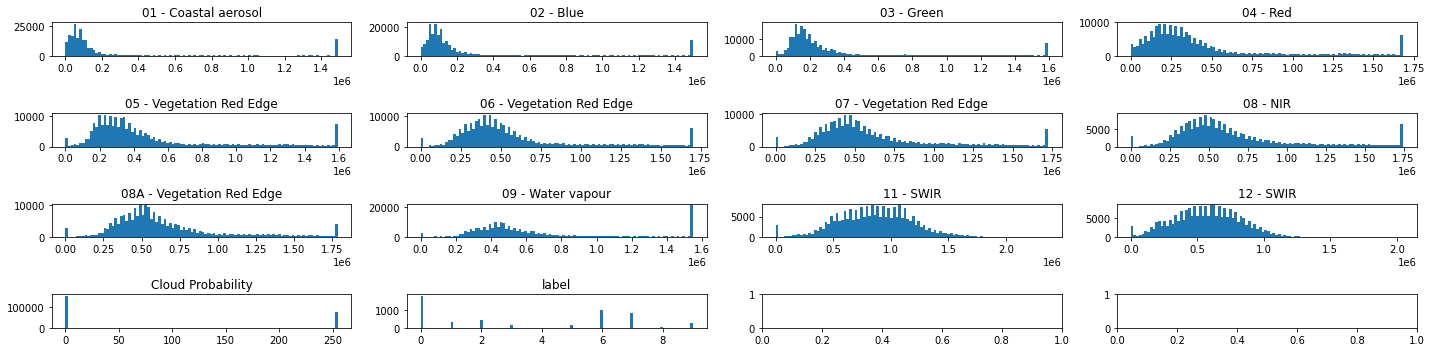

In [3]:
dataset, samples, band_values, band_stats = inspect_tools.load_and_veryify_samples(converter.PARTITION_DIR, n_samples=5, n_hist_bins=100)

label_count = np.bincount(band_values["label"])
print("labels per class", label_count)


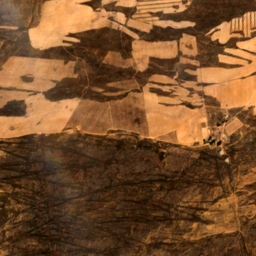
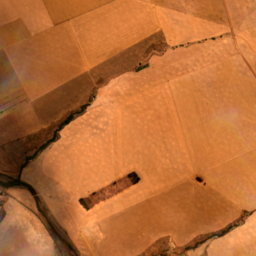
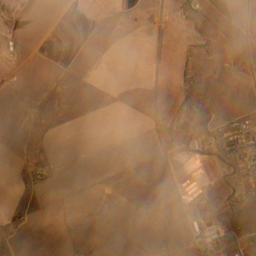
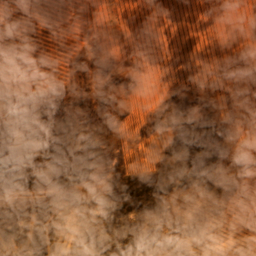
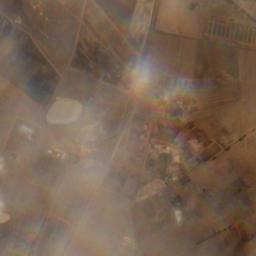


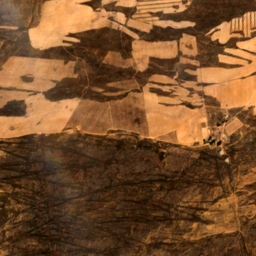
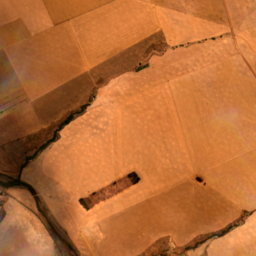
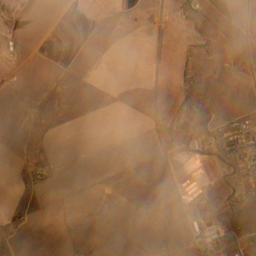
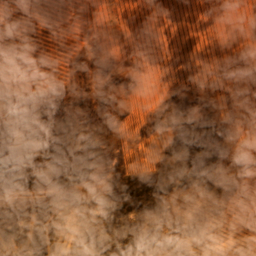
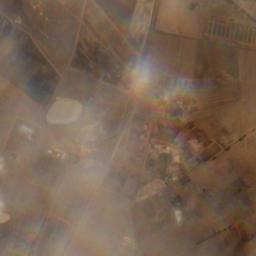

In [4]:
images, _ = inspect_tools.extract_images(samples)
ipyplot.plot_images(images=images, img_width=256, max_images=50)




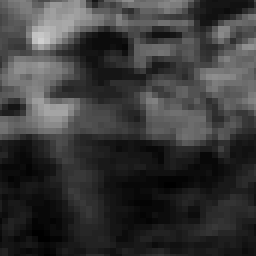
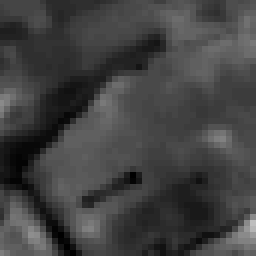
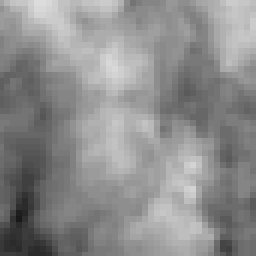
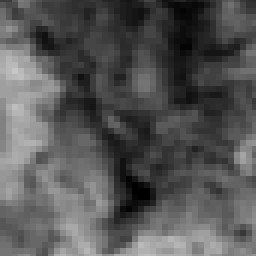
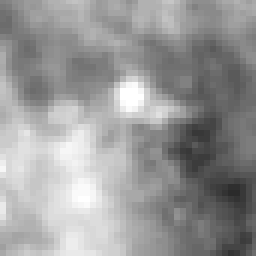
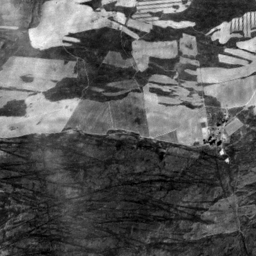
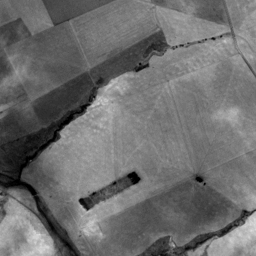
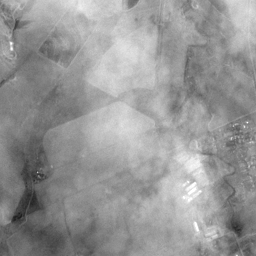
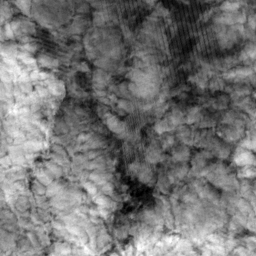
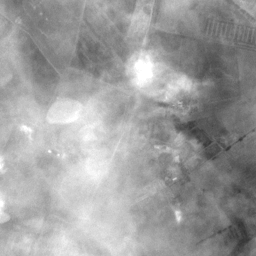
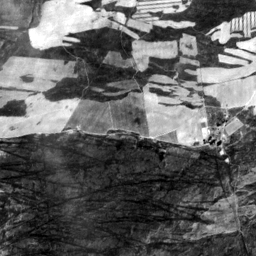
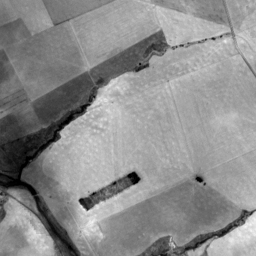
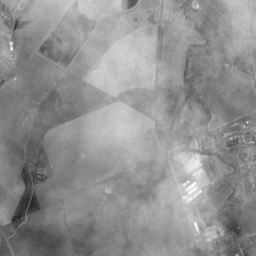
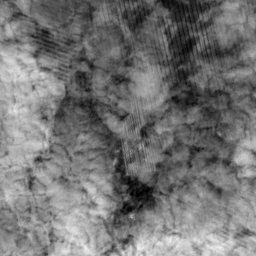
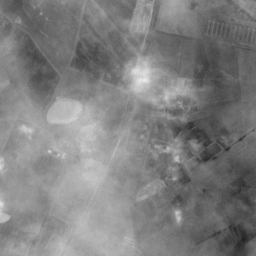
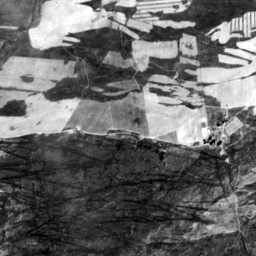
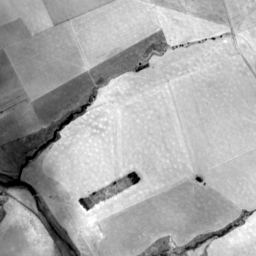
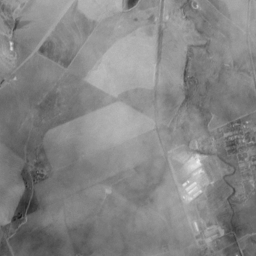
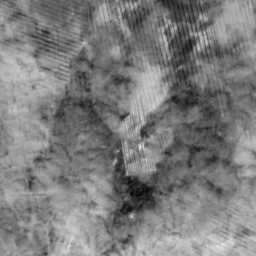
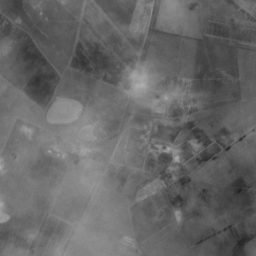
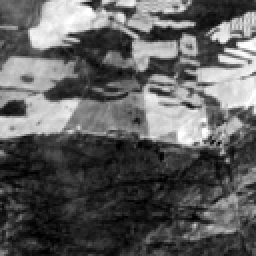
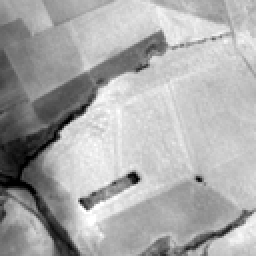
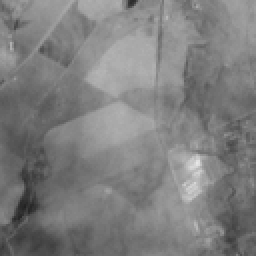
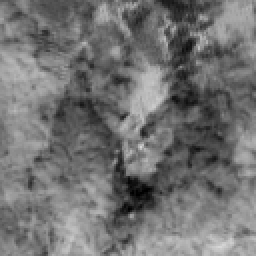
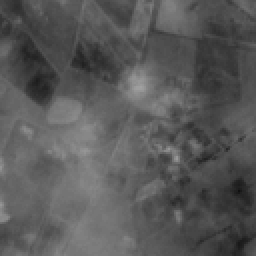
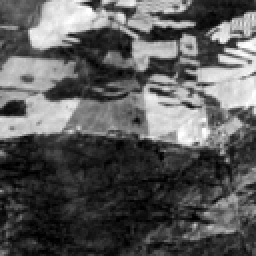
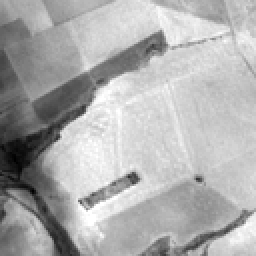
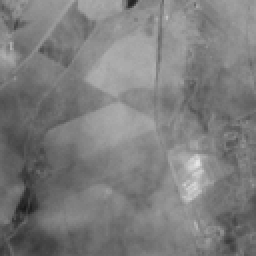
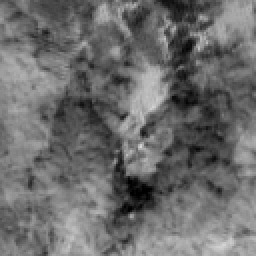
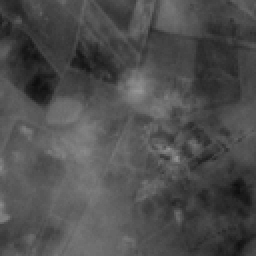
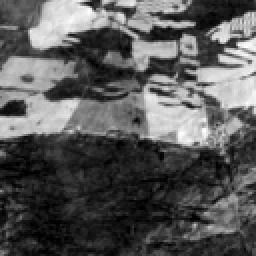
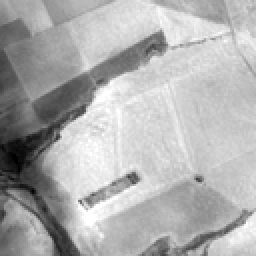
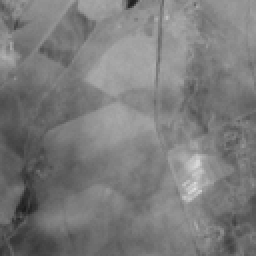
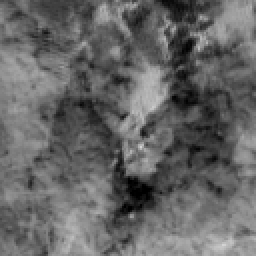
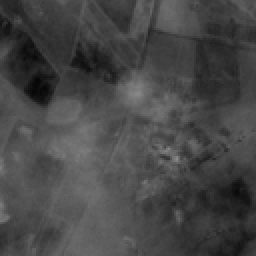
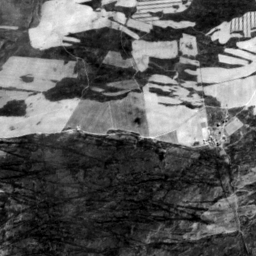
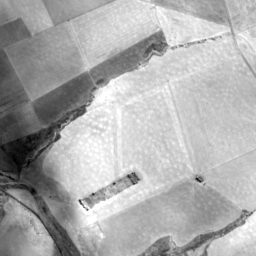
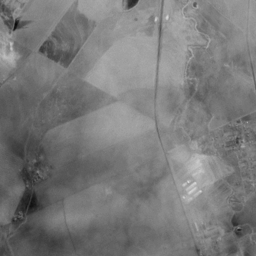
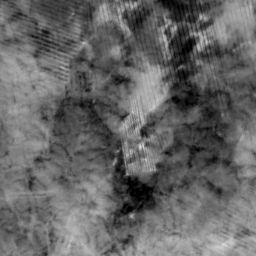
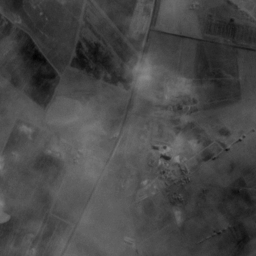
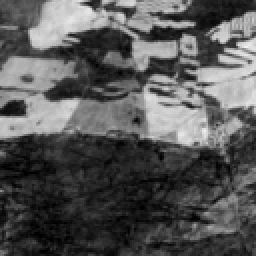
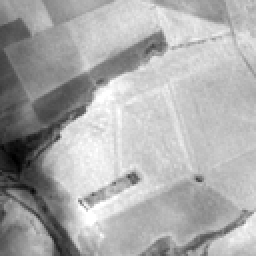
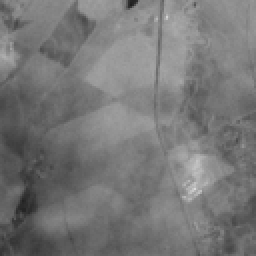
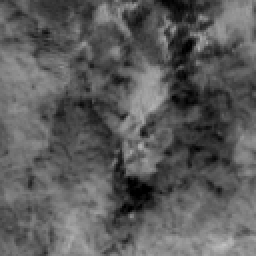
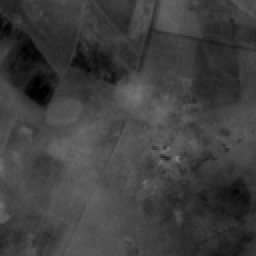
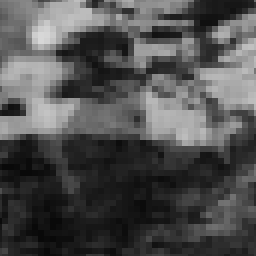
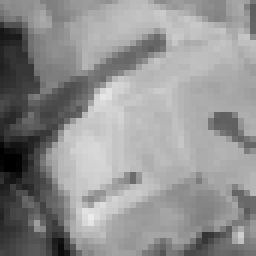
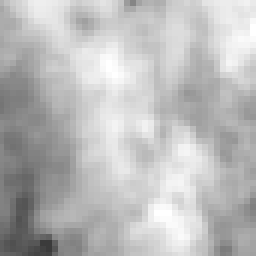
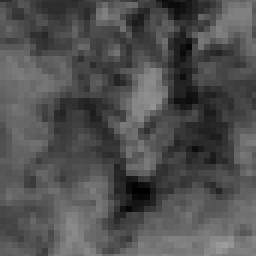
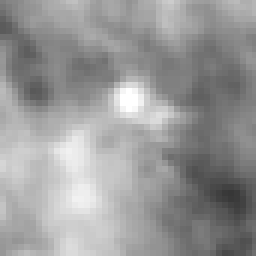
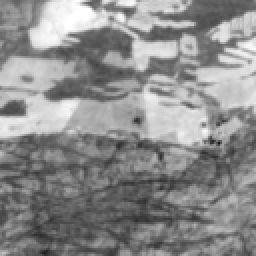
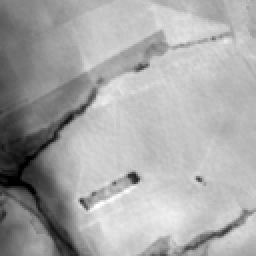
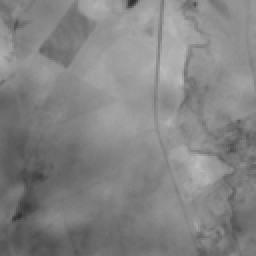
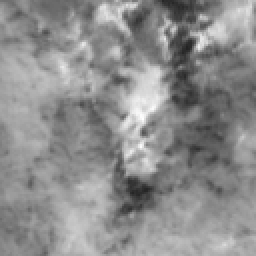
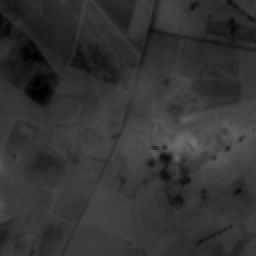
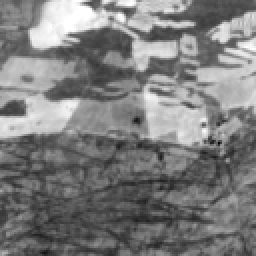
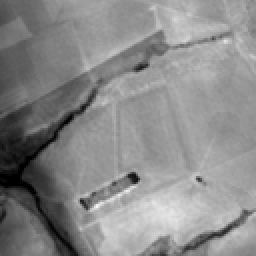
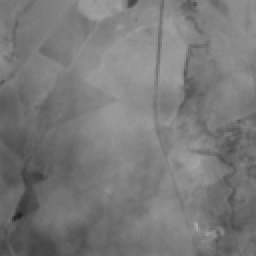
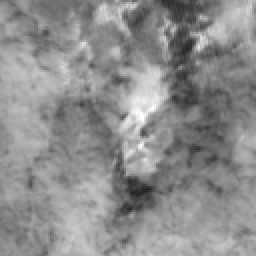
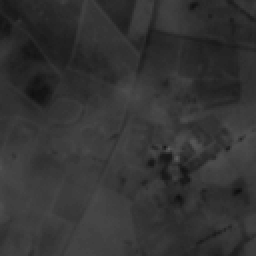
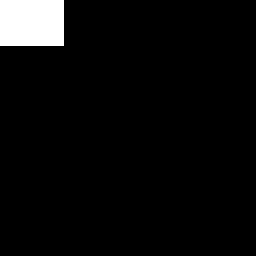
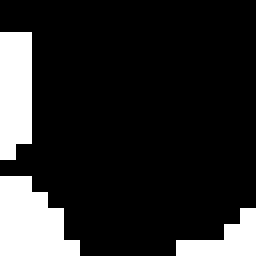
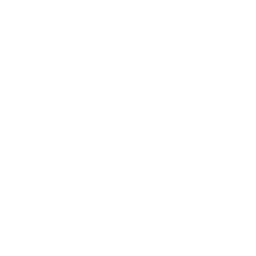
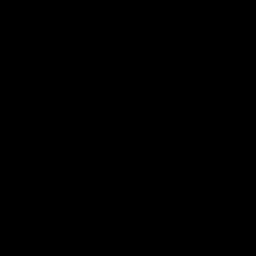
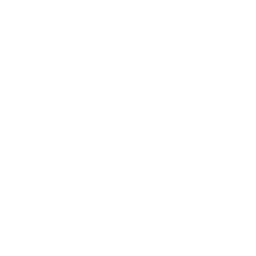
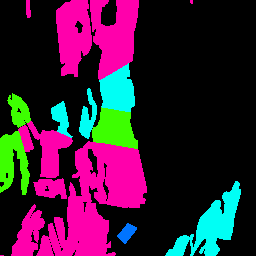
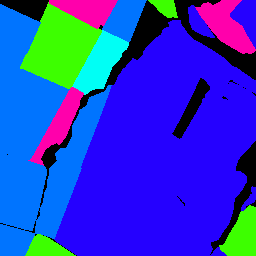
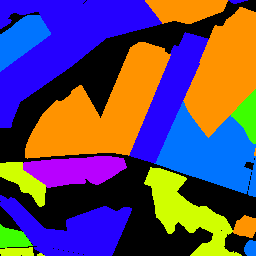
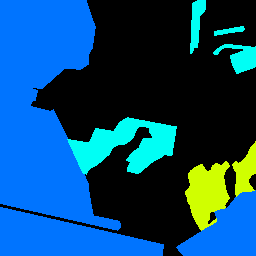
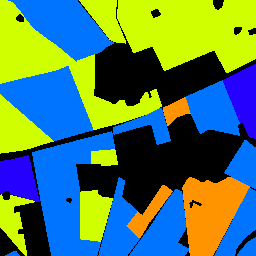


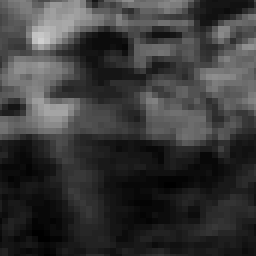
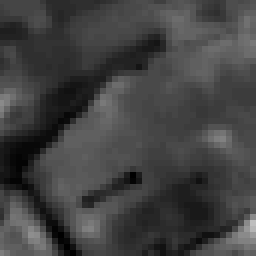
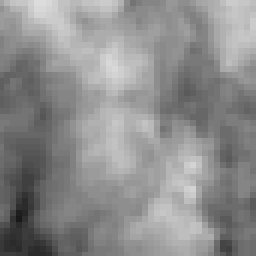
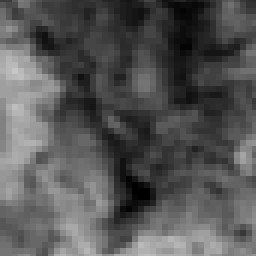
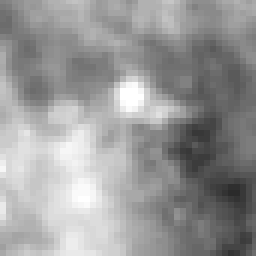
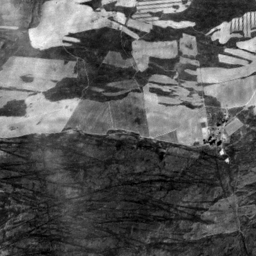
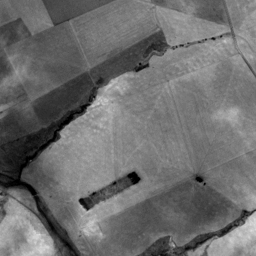
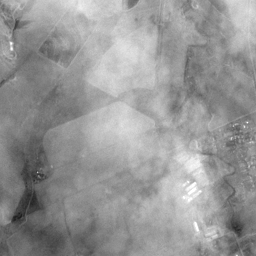
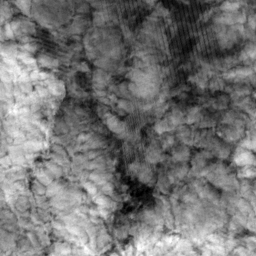
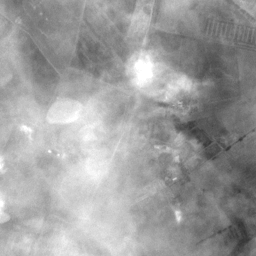
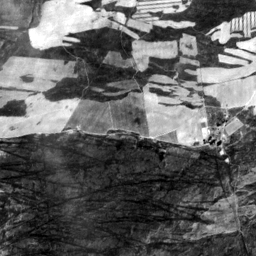
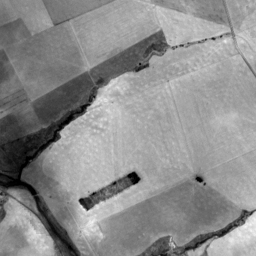
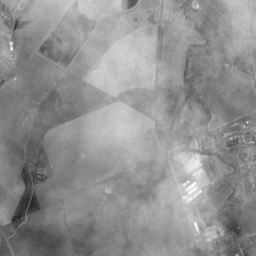
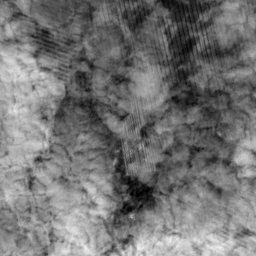
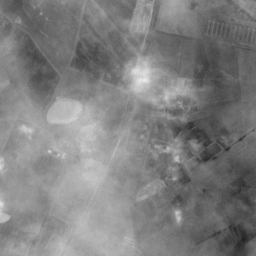
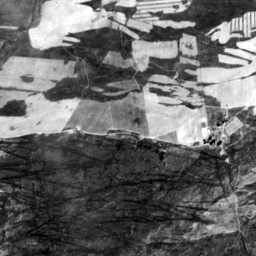
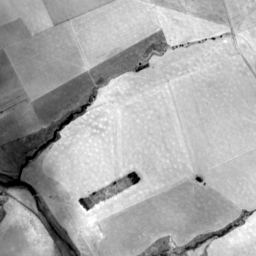
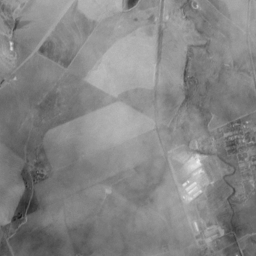
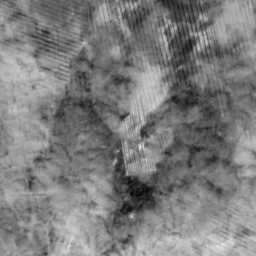
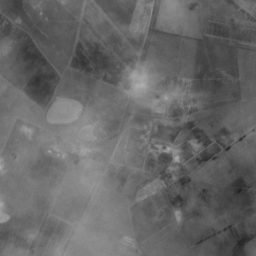
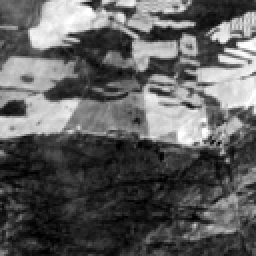
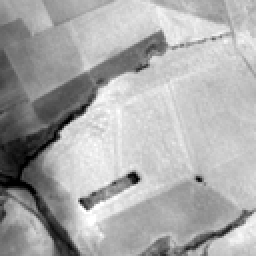
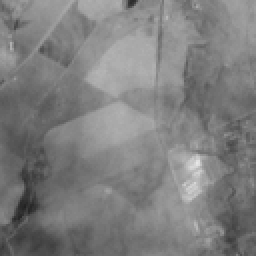
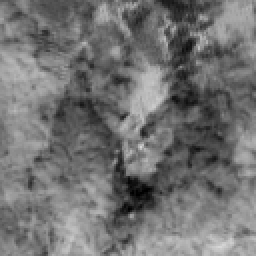
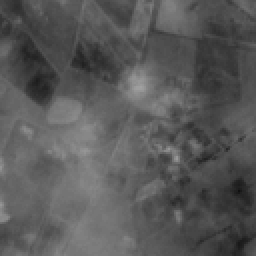
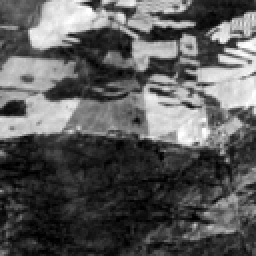
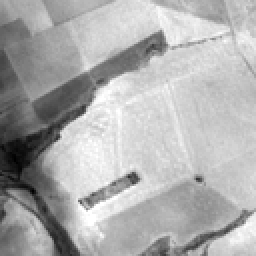
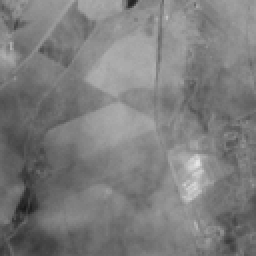
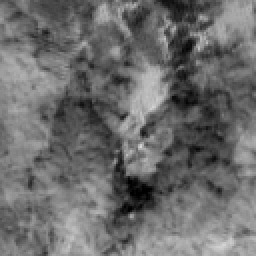
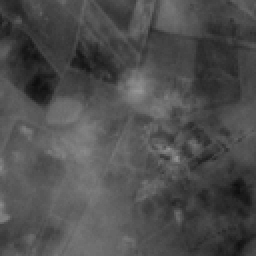
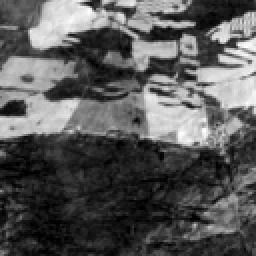
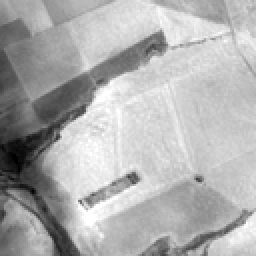
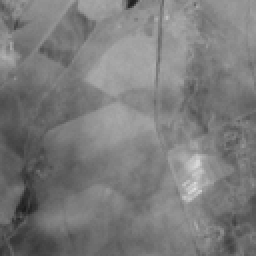
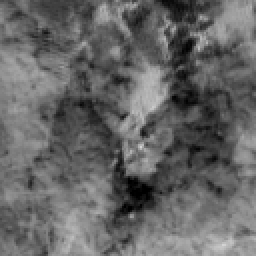
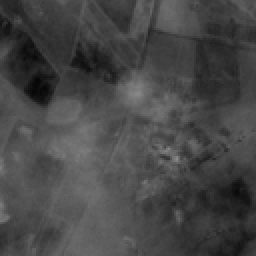
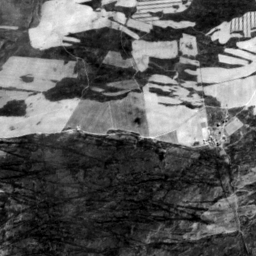
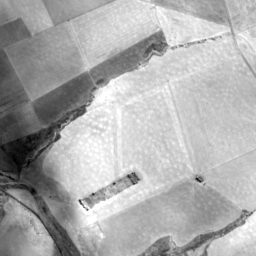
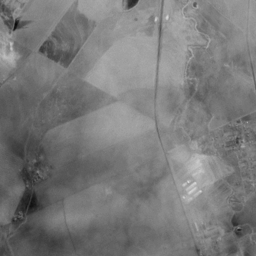
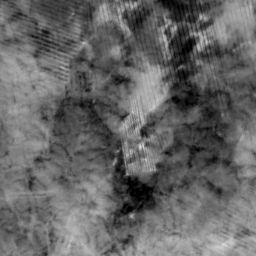
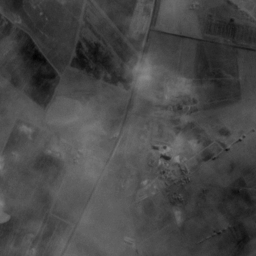
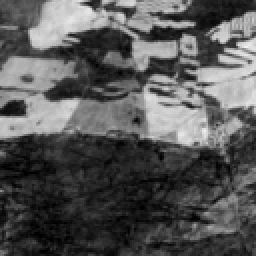
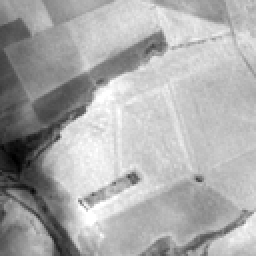
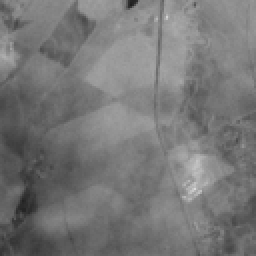
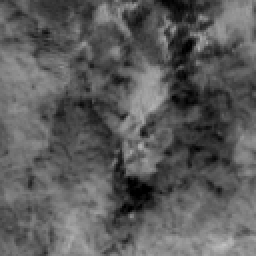
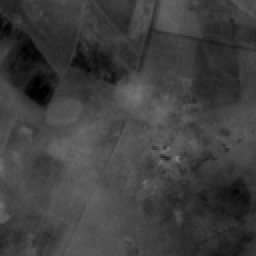
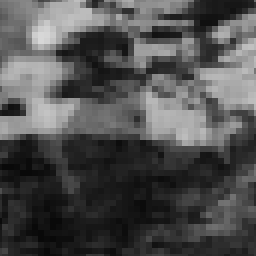
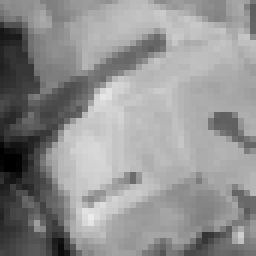
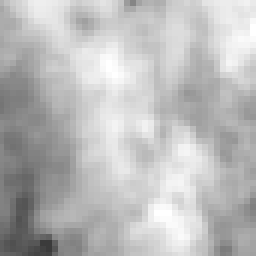
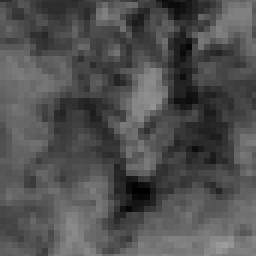
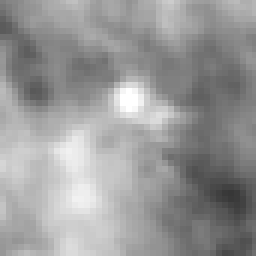
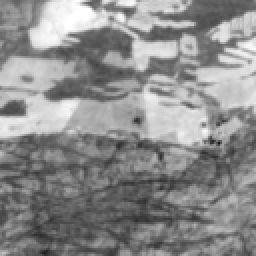
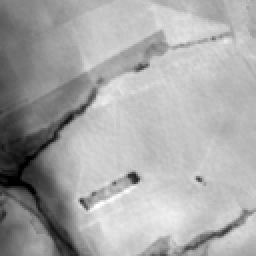
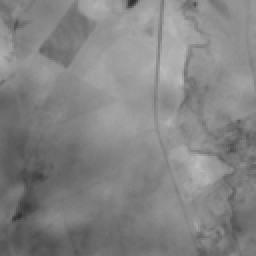
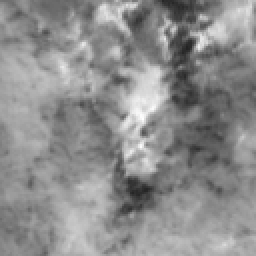
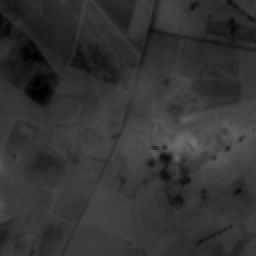
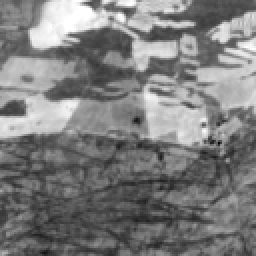
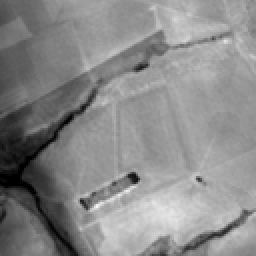
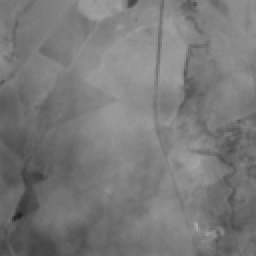
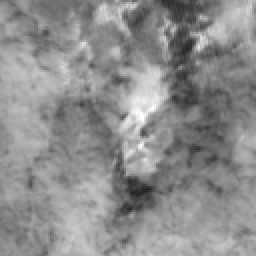
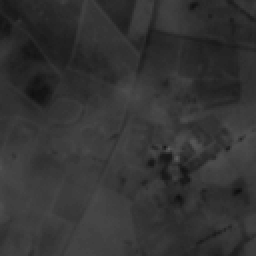
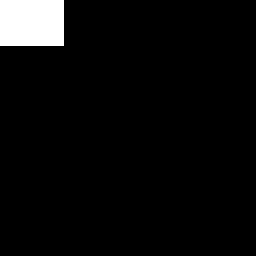
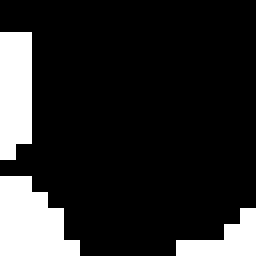
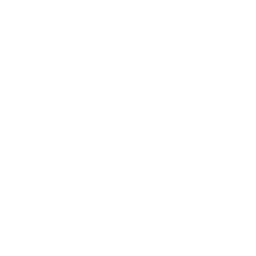
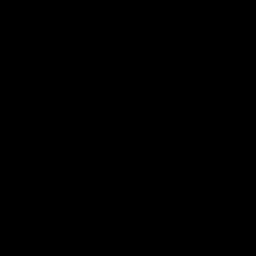
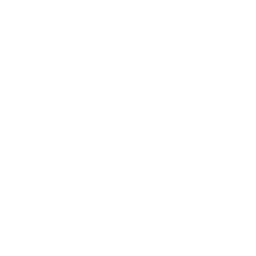
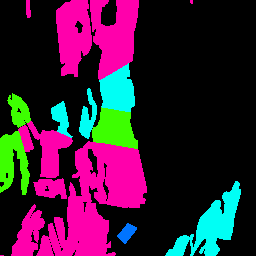
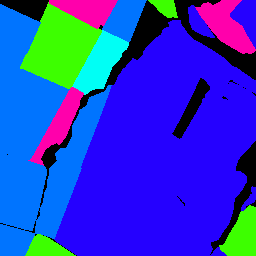
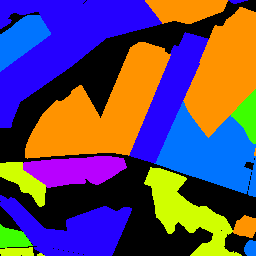
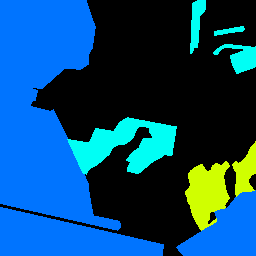
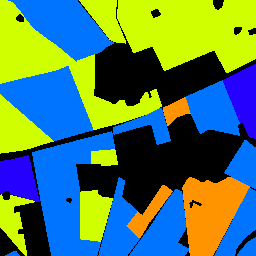

In [5]:
# labels seem augmented, they should be rotated 90 clockwise and then flipped horizontally
images, labels = inspect_tools.extract_bands(samples)
ipyplot.plot_class_tabs(images=images, labels=labels, img_width=256, max_imgs_per_tab=50)

In [7]:
import rasterio
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import os

(3, 256, 256)


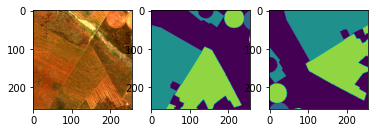

In [8]:

rgb_paths = [
    "/mnt/data/cc_benchmark/source/southAfricaCropType/ref_south_africa_crops_competition_v1_train_source_s2/ref_south_africa_crops_competition_v1_train_source_s2_0001_2017_07_10/B04.tif",
    "/mnt/data/cc_benchmark/source/southAfricaCropType/ref_south_africa_crops_competition_v1_train_source_s2/ref_south_africa_crops_competition_v1_train_source_s2_0001_2017_07_10/B03.tif",
    "/mnt/data/cc_benchmark/source/southAfricaCropType/ref_south_africa_crops_competition_v1_train_source_s2/ref_south_africa_crops_competition_v1_train_source_s2_0001_2017_07_10/B02.tif"
]

label_path = "/mnt/data/cc_benchmark/source/southAfricaCropType/ref_south_africa_crops_competition_v1_train_labels/ref_south_africa_crops_competition_v1_train_labels_0001/labels.tif"

rgb = []
for path in rgb_paths:
    src = rasterio.open(path)
    rgb.append(src.read())
rgb = crop_type_utils.percentile_normalization(np.concatenate(rgb, axis=0))
print(rgb.shape)

mask = rasterio.open(label_path).read()

load_mask = crop_type_utils.load_tif_mask(os.path.dirname(label_path), CRS.from_epsg(32634))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(rgb.transpose(1, 2, 0))
axs[1].imshow(mask.transpose(1, 2, 0))
axs[2].imshow(load_mask.transpose(2, 1, 0))
plt.show()

In [1]:
import datetime
import gc
import json
import os
import re
from pathlib import Path
from typing import List

import numpy as np
from ccb import io
from pyproj import Transformer
from rasterio.crs import CRS
from rasterio.transform import Affine
from tqdm import tqdm

import crop_type_utils
import matplotlib.pyplot as plt

In [2]:
DATASET_NAME = "southAfricaCropType"
SRC_DATASET_DIR = Path(io.CCB_DIR, "source", DATASET_NAME)
SRC_TRANSFORM = Affine(10.0, 0.0, 331040.0, 0.0, -10.0, -3714560.0)
SRC_CRS = CRS.from_epsg(32634)
LABEL_DIRECTORY_REGEX = r"""_(?P<id>[0-9]{4})$"""
IMG_DIRECTORY_REGEX = r"""
    _(?P<id>[0-9]{4})
    _(?P<year>[0-9]{4})
    _(?P<month>[0-9]{2})
    _(?P<day>[0-9]{2})$"""
PARTITION_CRS = SRC_CRS
PARTITION_DIR = Path(io.CCB_DIR, "converted", DATASET_NAME)

PATCH_SIZE = 256
LABEL_THRESH = 0.2  # minimum percentage of labels in image area
HEIGHT = 256
WIDTH = 256

crop_labels = [
    "No Data",
    "Lucerne/Medics",
    "Planted pastures (perennial)",
    "Fallow",
    "Wine grapes",
    "Weeds",
    "Small grain grazing",
    "Wheat",
    "Canola",
    "Rooibos",
]

CLASS2IDX = {c: i for i, c in enumerate(crop_labels)}

BANDNAMES = [
    "B01.tif",
    "B02.tif",
    "B03.tif",
    "B04.tif",
    "B05.tif",
    "B06.tif",
    "B07.tif",
    "B08.tif",
    "B8A.tif",
    "B09.tif",
    "B11.tif",
    "B12.tif",
    "CLM.tif",
]

img_dir = os.path.join(SRC_DATASET_DIR, "ref_south_africa_crops_competition_v1_train_source_s2")
label_dir = os.path.join(SRC_DATASET_DIR, "ref_south_africa_crops_competition_v1_train_labels")

In [6]:
label_dir_regex = re.compile(LABEL_DIRECTORY_REGEX, re.VERBOSE)
label_dir_paths = sorted(os.listdir(label_dir))[2:]  # skip aux files
img_dir_regex = re.compile(IMG_DIRECTORY_REGEX, re.VERBOSE)
img_dir_paths = sorted(os.listdir(img_dir))[1:]  # skip aux files

label_pct = []
for dirpath in tqdm(label_dir_paths):
    path = os.path.join(label_dir, dirpath)
    
    # find image bounds in stac.json file
    with open(os.path.join(label_dir, dirpath, "stac.json")) as f:
        data = json.load(f)

    # bboxes in source imagery stac.json are in epsg '4326'
    transformer = Transformer.from_crs(CRS.from_epsg(4326), PARTITION_CRS, always_xy=True)
    minx, miny, maxx, maxy = data["bbox"]

    # transform bounds to CRS of imagery
    (minx, maxx), (miny, maxy) = transformer.transform([minx, maxx], [miny, maxy])

    bounds = {"minx": minx, "maxx": maxx, "miny": miny, "maxy": maxy}


    # to extract date information and id to match input images
    match = re.search(label_dir_regex, path)
    id = "_source_" + match.group("id")


    label = crop_type_utils.load_tif_mask(
        filepath=path,
        dest_crs = PARTITION_CRS
    )

    mask = np.stack(label, axis=0)
    k = crop_type_utils.compute_area_with_labels(mask)
    label_pct.append(k)

100%|██████████| 2650/2650 [00:34<00:00, 77.91it/s] 


1602
0.6045283018867924


(array([2.65846664, 1.31216756, 0.97843708, 0.83811858, 0.70159248,
        0.74710118, 0.67125335, 0.62574464, 0.79260988, 0.72434683]),
 array([1.52587891e-05, 9.95193481e-02, 1.99023438e-01, 2.98527527e-01,
        3.98031616e-01, 4.97535706e-01, 5.97039795e-01, 6.96543884e-01,
        7.96047974e-01, 8.95552063e-01, 9.95056152e-01]),
 <BarContainer object of 10 artists>)

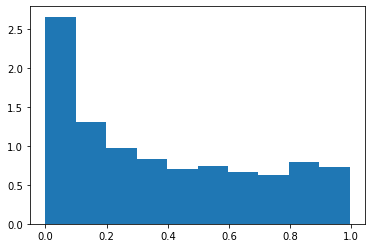

In [7]:
x = np.array(label_pct)
print(len(x[x>LABEL_THRESH]))
print(len(x[x>LABEL_THRESH])/len(x))
plt.hist(x, density=True, bins=10)